In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from scipy.special import gamma
from scipy.optimize import root, minimize
import itertools
from tqdm import tqdm
from itertools import product
from multiprocessing import Pool, cpu_count
from functools import partial
from fetch_coint_fn import fetch_coint_pairs

## Detect and get params

In [13]:
def calculate_params(series1, series2):
    x_with_const = sm.add_constant(series2)
    model = sm.OLS(series1, x_with_const)
    results = model.fit()
    intercept, beta = results.params
    return intercept, beta

def get_spread(series1, series2, beta):
    spread = series1 - (beta * series2)
    return spread

def get_zscore(spread):
    mean = np.mean(spread)
    std = np.std(spread)
    zscore = (spread - mean) / std
    return zscore

## Backtesting

In [14]:
def get_raw_df(symbol1, symbol2, df1, df2):
    """
    Spread = P1 - beta * P2
    long spread = long P1, short P2
    """
    if len(df1) != len(df2):
        return None

    raw_df = pd.DataFrame()

    raw_df = pd.concat([df1, df2], axis = 1)
    raw_df.columns = [
        "Timestamp", f"Open_{symbol1}", f"High_{symbol1}", f"Low_{symbol1}", f"Close_{symbol1}", f"Volume_{symbol1}", f"Turnover_{symbol1}",
        "Timestamp", f"Open_{symbol2}", f"High_{symbol2}", f"Low_{symbol2}", f"Close_{symbol2}", f"Volume_{symbol2}", f"Turnover_{symbol2}"
        ]
    raw_df = raw_df.loc[:,~raw_df.columns.duplicated()]
    raw_df.set_index("Timestamp", inplace = True)
    raw_df.index = pd.to_datetime(raw_df.index)

    raw_df["beta"] = calculate_params(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"])[1]
    raw_df["spread"] = get_spread(raw_df[f"Close_{symbol1}"], raw_df[f"Close_{symbol2}"], raw_df["beta"])
    Z = get_zscore(raw_df["spread"])

    raw_df["Z_score"] = Z
    raw_df["Entry_long"] = Z < -2
    raw_df["Exit_long"] = Z >= -0.5
    raw_df["Entry_short"] = Z > 2
    raw_df["Exit_short"] = Z <= 0.75

    return raw_df

In [ ]:
def backtest(raw_df, symbol1, symbol2, window_start = 0, window_end = None, Spot_fund = 10000, cost = 0.001):
    if raw_df is None:
        return None

    if window_start == 0 and window_end is None:
        testing_data = raw_df.copy()
    else:
        testing_data = raw_df.loc[window_start: window_end].copy()
    
    BS = None
    cols_to_init = [f"Spotsize_{symbol1}", f"Spotsize_{symbol2}", "Profit", "Profitfee", "cumReturn", "Drawdown"]
    testing_data[cols_to_init] = 0.0
    
    for i in range(len(testing_data)):
        if i == len(testing_data) - 1:
            break
        
        Timestamp = testing_data.index[i]
        nextTimestamp = testing_data.index[i + 1]
        if BS is None:
            if testing_data["Entry_long"].iloc[i]:
                BS = "B"
                entry_price1 = testing_data.loc[nextTimestamp, f"Close_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Close_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = (Spot_fund / 2) / testing_data[f"Close_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = - (Spot_fund / 2) / testing_data[f"Close_{symbol2}"].iloc[i]

            elif testing_data["Entry_short"].iloc[i]:
                BS = "S"
                entry_price1 = testing_data.loc[nextTimestamp, f"Close_{symbol1}"]
                entry_price2 = testing_data.loc[nextTimestamp, f"Close_{symbol2}"]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = - (Spot_fund / 2) / testing_data[f"Close_{symbol1}"].iloc[i]
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = (Spot_fund / 2) / testing_data[f"Close_{symbol2}"].iloc[i]
        
        elif BS in ["B", "S"]:
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol1}"]
            testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = testing_data.loc[Timestamp, f"Spotsize_{symbol2}"]
            testing_data.loc[Timestamp, "Profit"] = (testing_data.loc[nextTimestamp, f"Open_{symbol1}"] - testing_data.loc[Timestamp, f"Open_{symbol1}"]) * testing_data[f"Spotsize_{symbol1}"].iloc[i] + (testing_data.loc[nextTimestamp, f"Open_{symbol2}"] - testing_data.loc[Timestamp, f"Open_{symbol2}"]) * testing_data[f"Spotsize_{symbol2}"].iloc[i]
            if testing_data["Entry_long"].iloc[i - 1] or testing_data["Entry_short"].iloc[i - 1]:
                cost_amount = abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * entry_price1 * cost + \
                                abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * entry_price2 * cost
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"] - cost_amount
            else:
                testing_data.loc[Timestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"]
            
            if (BS == "B" and testing_data["Exit_long"].iloc[i]) or (BS == "S" and testing_data["Exit_short"].iloc[i]):
                BS = None
                exit_price1 = testing_data.loc[nextTimestamp, f"Open_{symbol1}"]
                exit_price2 = testing_data.loc[nextTimestamp, f"Open_{symbol2}"]
                cost_amount = abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"]) * exit_price1 * cost + \
                                abs(testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"]) * exit_price2 * cost
                testing_data.loc[nextTimestamp, "Profitfee"] = testing_data.loc[Timestamp, "Profit"] - cost_amount
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol1}"] = 0
                testing_data.loc[nextTimestamp, f"Spotsize_{symbol2}"] = 0

    testing_data["cumReturn"] = testing_data["Profitfee"].cumsum()
    peak = testing_data["cumReturn"].cummax()
    testing_data["Drawdown"] = - (testing_data["cumReturn"] - peak) / peak

    return testing_data

In [16]:
def get_performance(df, cost, freq_per_day = 24):
    if df is None:
        return None
    
    performance = {}
    profit_series = df["Profitfee"].dropna()
    negative_profit = profit_series[profit_series < 0]
    positive_profit = profit_series[profit_series > 0]

    performance["totalReturn"] = df["Profit"].sum()
    performance["totalProfitfee"] = df["Profitfee"].sum()
    performance["AnnualizedReturn"] = profit_series.mean() * freq_per_day * 365
    performance["Win Rate"] = len(positive_profit) / len(profit_series) if len(profit_series) != 0 else 0
    performance["SharpeRatio"] = profit_series.mean() / profit_series.std() if profit_series.std() != 0 else np.nan
    performance["SortinoRatio"] = profit_series.mean() / negative_profit.std() if negative_profit.std() != 0 else np.nan
    performance["ProfitFactor"] = positive_profit.sum() / abs(negative_profit.sum()) if abs(negative_profit.sum()) != 0 else np.inf
    performance["MaxDrawdown"] = df["Drawdown"].min()

    return performance

In [17]:
def get_new_main_df(df, symbol1, symbol2):
    new_main_df = df[["Profit", "Profitfee"]].copy()
    new_main_df["Timestamp"] = df.index
    new_main_df["Pairs"] = (symbol1 + " - " + symbol2)
    new_main_df["Pairs"] = new_main_df["Pairs"].astype("category")

    cols = ["Pairs", "Profit", "Profitfee"]
    new_main_df = new_main_df[cols]

    return new_main_df

In [ ]:
def rolling(main_df, train_ratio, n_window, spot_sector_map, spot_folder, cost, focus_indicator = "totalReturn"):
    """
    有時候不能整除，所以可能會多一個window
    """
    total_size = len(main_df)
    test_ratio = 1 - train_ratio
    
    window = total_size // (1 + test_ratio * (n_window - 1))
    train_size = int(window * train_ratio)
    test_size = int(window * test_ratio)

    start = 0
    window_num = 0
    train_results = []

    while start + train_size + test_size <= total_size:
        print(f"Processing window {window_num + 1}")

        train = main_df.iloc[start : start + train_size]
        train_start_time = train.index[0]
        train_end_time = train.index[-1]
        print(f"{train_start_time}-{train_end_time}")
        
        # fetch cointegrated pairs by parralel processing(up to 8 workers)
        coint_pairs = fetch_coint_pairs(spot_sector_map, spot_folder, train_start_time, train_end_time, max_workers = 6)
        for pair_data in coint_pairs:
            sector = pair_data["sector"]
            symbol1, symbol2 = pair_data["pair"][0], pair_data["pair"][1]

            df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
            df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
            raw_df = get_raw_df(symbol1, symbol2, df1, df2)
            training_df = backtest(raw_df, symbol1, symbol2, train_start_time, train_end_time)
            if training_df is None:
                continue
            performance = get_performance(training_df, cost)
            train_results.append({
                "sector": sector,
                "pair": (symbol1, symbol2),
                "performance": performance
            })

        sorted_results = sorted(train_results, key = lambda x: x["performance"][focus_indicator], reverse = True)
        sorted_df = pd.DataFrame(sorted_results)
        sorted_df.to_csv("sorted_results.csv")
        best_pair = sorted_results[0]
        symbol1, symbol2 = best_pair["pair"][0], best_pair["pair"][1]

        test = main_df.iloc[start + train_size : start + train_size + test_size]
        testing_start_time = test.index[0]
        testing_end_time = test.index[-1]

        df1 = pd.read_csv(f"{spot_folder}/{symbol1}.csv")
        df2 = pd.read_csv(f"{spot_folder}/{symbol2}.csv")
        raw_df = get_raw_df(symbol1, symbol2, df1, df2)
        testing_df = backtest(raw_df, symbol1, symbol2, testing_start_time, testing_end_time)
        try:
            testing_df.to_csv("test.csv")
        except:
            pass
        if testing_df is None:
            continue

        performance = get_performance(testing_df, cost)
        new_main_df = get_new_main_df(testing_df, symbol1, symbol2)
        main_df.update(new_main_df)
        start += test_size
        window_num += 1

    main_df["cumReturn"] = main_df["Profitfee"].cumsum()
    peak = main_df["cumReturn"].cummax()
    try:
        main_df["Drawdown"] = - (main_df["cumReturn"] - peak) / peak
    except:
        main_df["Drawdown"] = 0
        
    return main_df

In [19]:
spot_sector = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/metadata/spot_sector_map.json"
spot_folder = "/Users/xinc./Documents/GitHub/Quant/data/crypto_database/spot"

with open(spot_sector, "r") as f:
    spot_sector_map = json.load(f)

start = "2022-01-01 00:00:00+08:00"
end = "2025-03-30 21:00:00+08:00"
train_interval = 2 # months
test_interval = 1 # months

main_df = pd.DataFrame(index = pd.date_range(start, end, freq = "h"), columns = ["Pairs", "Profit", "Profitfee", "cumReturn", "Drawdown"])
train_size, test_size = train_interval * 30 * 24, test_interval * 30 * 24
window_size = train_size + test_size
train_ratio = train_size / (train_size + test_size)
n_window = (len(main_df) - train_size - test_size) // test_size + 1

In [ ]:
print(train_size, test_size, window_size, train_ratio, n_window)

28438
1440 720 2160 0.6666666666666666 37


In [ ]:
main_df = rolling(main_df, train_ratio, n_window, spot_sector_map, spot_folder, 0.001)
main_df.to_csv("main_df.csv")

Processing window 1
2022-01-01 00:00:00+08:00-2022-03-02 17:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 13.96it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  8.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 18.31it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.29it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.33it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 16.80it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 2
2022-01-31 09:00:00+08:00-2022-04-02 02:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 11.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.36it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.47it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.80it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.49it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 13.85it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.57s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 3
2022-03-02 18:00:00+08:00-2022-05-02 11:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 11.69it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.68it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.40it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.63it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.09it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:04<00:00,  2.16it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 13.93it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 4
2022-04-02 03:00:00+08:00-2022-06-01 20:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 13.93it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 18.77it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.13it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.43it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 15.82it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 5
2022-05-02 12:00:00+08:00-2022-07-02 05:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 15.08it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 16.88it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.42it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.59it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 18.22it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 6
2022-06-01 21:00:00+08:00-2022-08-01 14:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.97it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.82it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.58it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 16.97it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.75it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 16.28it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 7
2022-07-02 06:00:00+08:00-2022-08-31 23:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.62it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.87it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.59it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 16.68it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.71it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.83it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 16.06it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 8
2022-08-01 15:00:00+08:00-2022-10-01 08:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.83it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.56it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.52it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 17.18it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.88it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.81it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 16.39it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.56it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 9
2022-09-01 00:00:00+08:00-2022-10-31 17:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 11.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:08<00:00, 14.69it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  8.13it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.35it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 14.02it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 10
2022-10-01 09:00:00+08:00-2022-12-01 02:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 11.59it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  8.67it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:09<00:00, 13.00it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.50it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:03<00:00,  3.01it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 17.72it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.37s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 11
2022-10-31 18:00:00+08:00-2022-12-31 11:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.66it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.33it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.73it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.53it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 13.82it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.47it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 12
2022-12-01 03:00:00+08:00-2023-01-30 20:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 14.77it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.30it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 19.13it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.26it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.43it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 15.50it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 13
2022-12-31 12:00:00+08:00-2023-03-02 05:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 18.12it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.64it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.19it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 23.17it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 15.02it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.98it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:02<00:00, 23.90it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 14
2023-01-30 21:00:00+08:00-2023-04-01 14:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 17.53it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.82it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.25it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 22.82it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 15.82it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  6.16it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:02<00:00, 23.98it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 15
2023-03-02 06:00:00+08:00-2023-05-01 23:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 17.00it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.39it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:10<00:00, 11.74it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.95it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.70it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 21.46it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.61it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 16
2023-04-01 15:00:00+08:00-2023-06-01 08:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 13.37it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.03s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.79it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:50<00:00,  2.39it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  8.48it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:08<00:00,  1.21it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:09<00:00,  6.72it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:02<00:00,  2.08s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:10<00:00,  1.79s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 17
2023-05-02 00:00:00+08:00-2023-07-01 17:00:00+08:00


100%|██████████| 55/55 [00:05<00:00, 10.72it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.33it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:11<00:00, 10.08it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 13.12it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:02<00:00, 23.25it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.78it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 18
2023-06-01 09:00:00+08:00-2023-08-01 02:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 17.58it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.64it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 20.06it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.38it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.06it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 20.91it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 19
2023-07-01 18:00:00+08:00-2023-08-31 11:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 15.65it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.28it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 21.47it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 14.62it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:02<00:00, 22.86it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.74it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 20
2023-08-01 03:00:00+08:00-2023-09-30 20:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 16.58it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.41it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 20.34it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 14.74it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.93it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 17.77it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.72it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 21
2023-08-31 12:00:00+08:00-2023-10-31 05:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 14.78it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  4.00it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 21.09it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.62it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.66it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 21.41it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:03<00:00,  1.88it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 22
2023-09-30 21:00:00+08:00-2023-11-30 14:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 15.88it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.65it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 20.29it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 13.79it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 21.54it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.47it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 23
2023-10-31 06:00:00+08:00-2023-12-30 23:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 14.72it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.06it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 18.04it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 14.83it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.73it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 17.54it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.61it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 24
2023-11-30 15:00:00+08:00-2024-01-30 08:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 16.79it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 11.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.92it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 19.92it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 14.62it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 20.53it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.62it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 25
2023-12-31 00:00:00+08:00-2024-02-29 17:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 15.00it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.01s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.74it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.59it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 17.90it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.50it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.93it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 19.06it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 26
2024-01-30 09:00:00+08:00-2024-03-31 02:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 14.90it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.58it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.75it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 17.87it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.68it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.79it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 18.28it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 27
2024-02-29 18:00:00+08:00-2024-04-30 11:00:00+08:00


100%|██████████| 55/55 [00:06<00:00,  8.48it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:05<00:00,  5.18it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:03<00:00,  1.63it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:13<00:00,  9.22it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.57it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:03<00:00,  2.97it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:06<00:00, 10.29it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:03<00:00,  1.53it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 28
2024-03-31 03:00:00+08:00-2024-05-30 20:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 18.25it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.96it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.65it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:05<00:00, 21.07it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 16.12it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.87it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:02<00:00, 22.12it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 29
2024-04-30 12:00:00+08:00-2024-06-30 05:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.96it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.31it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.70it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:09<00:00, 12.86it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.99it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  3.84it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 14.52it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.00s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 30
2024-05-30 21:00:00+08:00-2024-07-30 14:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.84it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  7.77it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.52it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:08<00:00, 14.76it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.57it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.62it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 15.40it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 31
2024-06-30 06:00:00+08:00-2024-08-29 23:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 14.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.65it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 16.64it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.34it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.88it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 16.06it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.40it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 32
2024-07-30 15:00:00+08:00-2024-09-29 08:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 13.24it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.09it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.79it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.41it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:01<00:00, 14.46it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 18.21it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.57it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 33
2024-08-30 00:00:00+08:00-2024-10-29 17:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 13.86it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.54it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.62it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 13.43it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.99it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 16.80it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 34
2024-09-29 09:00:00+08:00-2024-11-29 02:00:00+08:00


100%|██████████| 55/55 [00:03<00:00, 13.78it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 10.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.66it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 17.21it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 13.00it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.62it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 18.24it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 35
2024-10-29 18:00:00+08:00-2024-12-29 11:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.76it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:03<00:00,  9.28it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.55it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.91it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.38it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.67it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 15.87it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.80it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.38it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 36
2024-11-29 03:00:00+08:00-2025-01-28 20:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.88it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.30it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:07<00:00, 15.48it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.58it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.41it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:04<00:00, 15.83it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Processing window 37
2024-12-29 12:00:00+08:00-2025-02-28 05:00:00+08:00


100%|██████████| 55/55 [00:04<00:00, 12.62it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00,  9.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.81it/s]
0it [00:00, ?it/s]
100%|██████████| 120/120 [00:06<00:00, 17.24it/s]
0it [00:00, ?it/s]
100%|██████████| 28/28 [00:02<00:00, 12.59it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:02<00:00,  4.97it/s]
0it [00:00, ?it/s]
100%|██████████| 66/66 [00:03<00:00, 17.02it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 6/6 [00:01<00:00,  3.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


<Axes: >

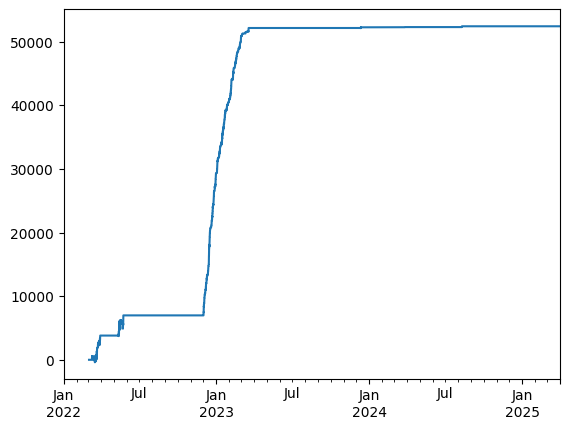

In [23]:
main_df["cumReturn"].plot()

1362


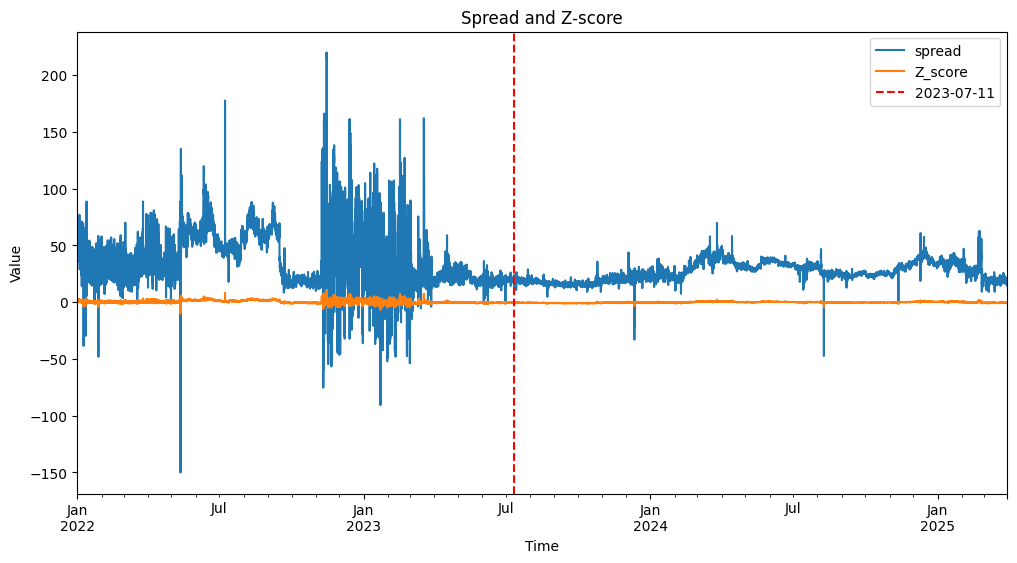

In [24]:
test = pd.read_csv("test.csv")
test["Timestamp"] = pd.to_datetime(test["Timestamp"])
test.set_index("Timestamp", inplace=True)

print(test["Entry_short"].sum())

ax = test[['spread', "Z_score"]].plot(figsize=(12, 6))

plt.axvline(pd.Timestamp("2023-07-11"), color='red', linestyle='--', label='2023-07-11')

plt.legend()
plt.title("Spread and Z-score")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()